In [1]:
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import numpy as np
from matplotlib import pyplot as plt
import math

from tqdm import tqdm

In [2]:
parsed_data = pd.read_pickle("output_df.pkl")

In [3]:
arr = pd.DataFrame(columns=["neural", "targetPosition"])

counter = 0
pca_split_index = 0
row_count = 0


for row in tqdm(parsed_data.iterrows()):
    if row[1]["targetPosition"][0] == np.float32(0.8):
        pca_split_index = counter
    else:
        row_count += 1
    for i in row[1]["neural"]:
        
        # build df for each neural, with the reach positions
        
        append_tuple = (i, row[1]["targetPosition"])
    
        arr = arr.append(pd.DataFrame([append_tuple], columns=["neural", "targetPosition"]))
        
        if pca_split_index == 0:
            counter = counter + 1


193it [00:09, 19.49it/s]


In [4]:
neural_data = np.array(arr["neural"].tolist())

for i in range(96):
    arr[str(i)] = neural_data[:, i]
    
arr["targetPosition"] = arr["targetPosition"].apply(lambda x: False if x[0] == np.float32(0.2) else True)

In [9]:
def automate_pca_and_plot(arr, n_components=3):
    pca = PCA(n_components=n_components)
    input_pca = pca.fit_transform(np.array(arr["neural"].tolist()))
    
    pca_columns = [f"PCA{i+1}" for i in range(n_components)]
    input_pca_df = pd.DataFrame(input_pca, columns=pca_columns)
    
    input_pca_df["targetPosition"] = arr["targetPosition"].tolist()

    input_pca_df_1 = input_pca_df[input_pca_df["targetPosition"].apply(lambda x: not x)]
    input_pca_df_2 = input_pca_df[input_pca_df["targetPosition"].apply(lambda x: x )]

    return plot_pca_histograms_multiple(input_pca_df_1, input_pca_df_2, n_components)

def plot_pca_histograms_multiple(input_pca_df_1, input_pca_df_2, n_components=3, wrap_after=3):
    n_rows = math.ceil(n_components / wrap_after)
    n_cols = min(n_components, wrap_after)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = ax.flatten()

    for i in range(n_components):
        component = f"PCA{i+1}"
        
        ax[i].hist(input_pca_df_1[component], density=True, bins=120, color="Blue", alpha=0.5, label='Dataset 1')
        ax[i].hist(input_pca_df_2[component], density=True, bins=120, color="Orange", alpha=0.5, label='Dataset 2')
        
        ax[i].set_title(f"{component}")
        ax[i].set_xlabel(component)
        ax[i].set_ylabel("Density")
        ax[i].legend()

    for j in range(n_components, n_rows * n_cols):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()
    
    return (input_pca_df_1, input_pca_df_2, n_components)


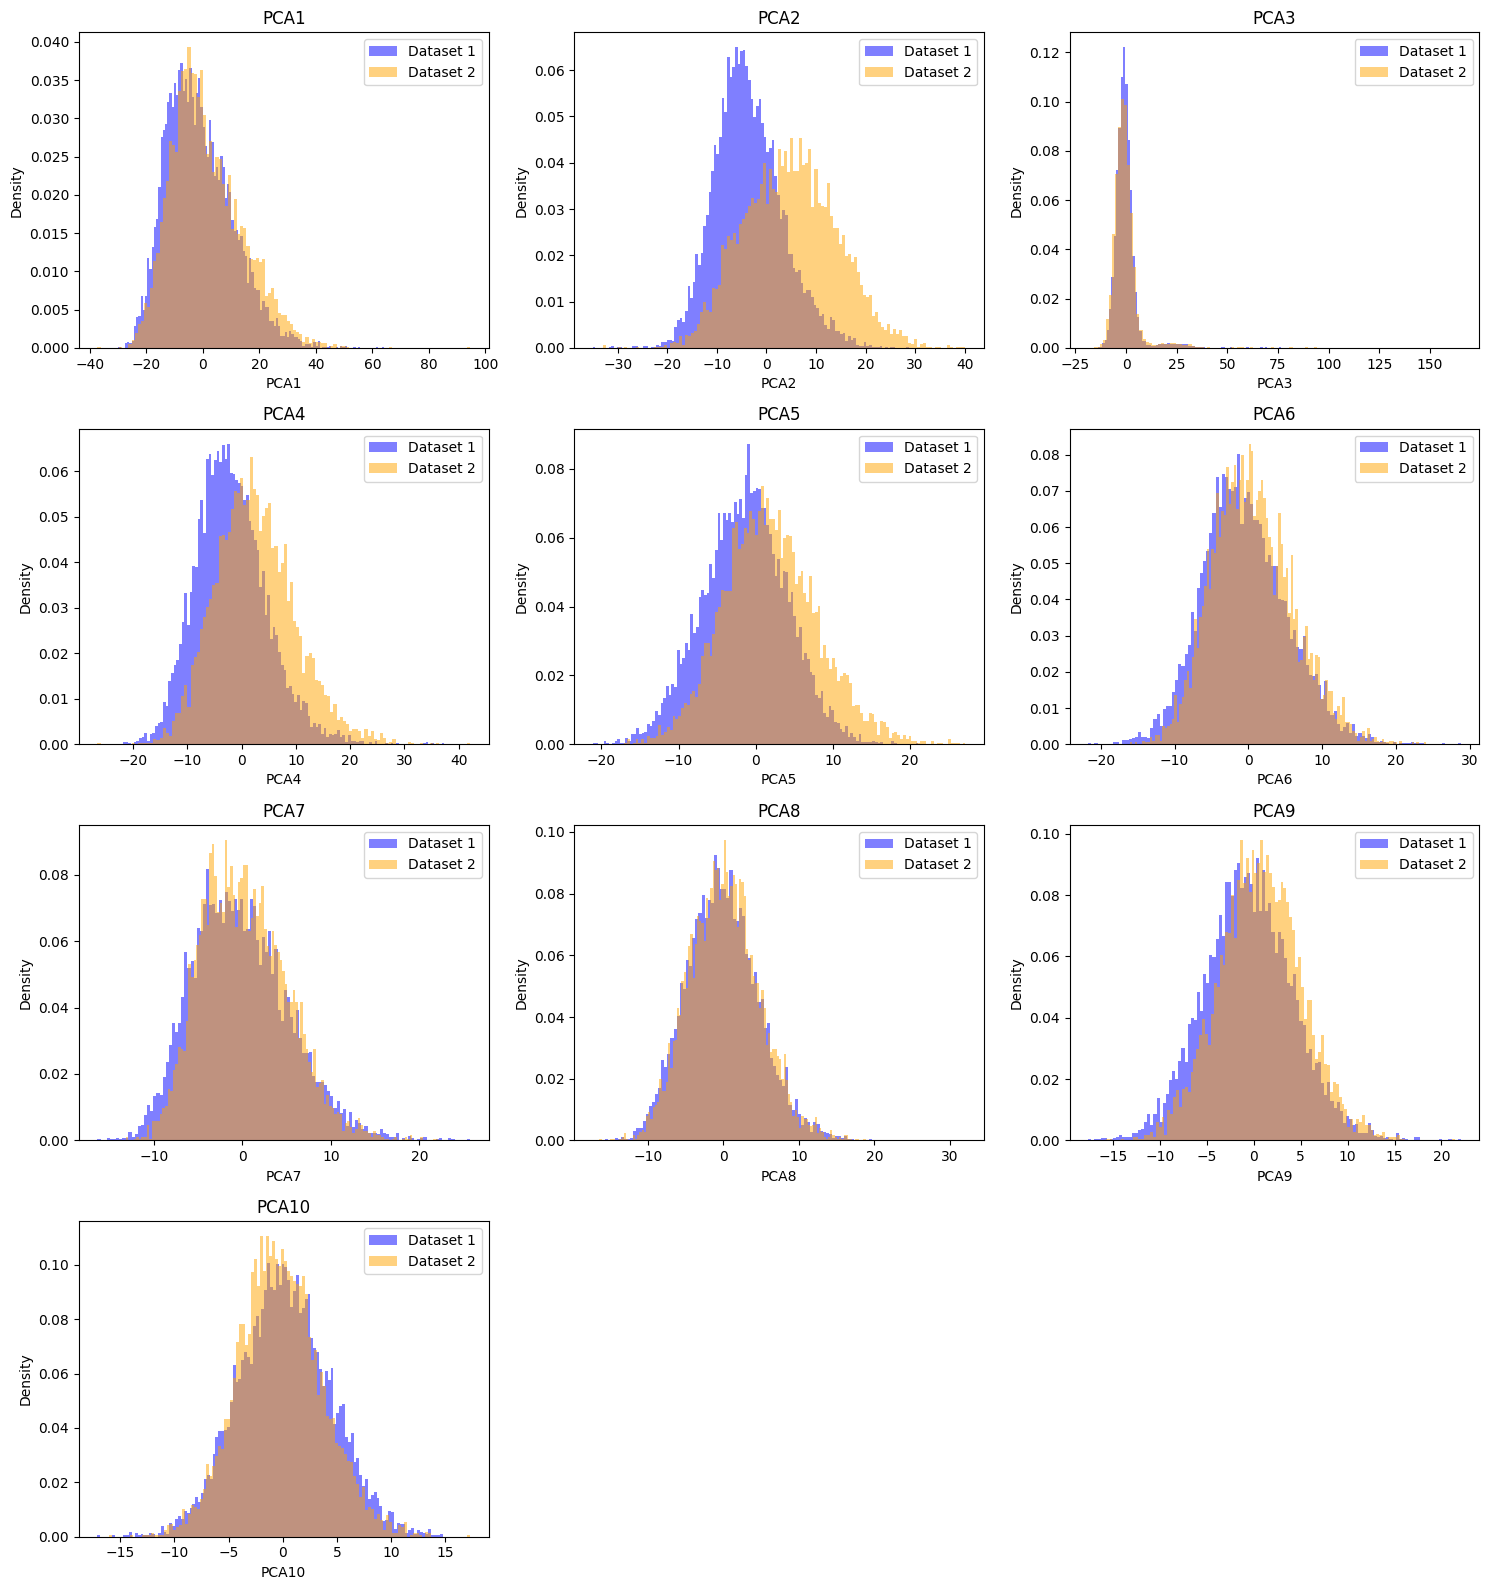

In [46]:
(pca1, pca2, n) = automate_pca_and_plot(arr, n_components=10)

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score


pca_merged = pd.concat([pca1, pca2])
X_train, X_test, y_train, y_test = train_test_split(
    pca_merged[["PCA2", "PCA4","PCA5", "PCA9"]], pca_merged["targetPosition"], test_size=0.20
)


In [146]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [144]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_resampled, y_resampled)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7849151930710935


In [112]:
copy_arr = arr.copy()

target_position = np.array(copy_arr["targetPosition"].tolist())

neural_data = copy_arr.drop(columns=["targetPosition"])
neural_data.drop(columns=["neural"], inplace=True)
neural_data

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,9.750000,23.750000,14.333333,11.444444,5.722222,6.944444,21.000000,11.138889,12.555556,8.750000,...,13.944444,10.111111,9.277778,26.972222,23.222222,13.611111,5.888889,13.277778,25.305556,10.750000
0,12.100000,10.275000,17.425000,14.950000,8.050000,6.800000,21.550000,11.850000,11.325000,9.100000,...,14.850000,9.125000,7.775000,29.325000,27.050000,18.625000,8.400000,13.575000,12.200000,8.775000
0,10.450000,10.575000,16.150000,15.250000,7.550000,9.075000,21.325000,8.400000,9.875000,7.800000,...,19.025000,7.325000,8.600000,28.900000,23.200000,14.475000,8.675000,11.800000,11.975000,9.300000
0,13.121951,9.048780,14.195122,14.000000,8.121951,8.048780,22.512195,13.902439,11.975610,9.292683,...,19.121951,8.365854,8.024390,27.268293,19.365854,14.780488,9.365854,13.926829,11.097561,8.853659
0,11.325000,19.675000,18.325000,14.350000,6.375000,6.825000,18.650000,9.800000,9.475000,6.225000,...,17.125000,11.600000,9.300000,28.525000,26.125000,15.925000,7.450000,10.900000,21.375000,13.225000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7.700000,11.800000,11.600000,12.350000,5.050000,6.700000,10.975000,9.525000,8.700000,8.475000,...,14.100000,9.125000,10.575000,26.975000,28.800000,17.325000,8.050000,11.600000,12.725000,9.925000
0,13.325000,11.350000,10.175000,9.475000,6.325000,7.525000,12.275000,7.400000,7.475000,8.825000,...,15.200000,7.475000,8.825000,30.975000,18.075000,14.550000,8.125000,11.025000,13.050000,6.400000
0,10.450000,12.650000,8.525000,10.525000,6.900000,6.750000,10.850000,7.900000,9.025000,8.500000,...,20.850000,8.675000,10.500000,27.625000,16.875000,11.850000,8.075000,8.325000,15.900000,8.650000
0,10.829268,11.951220,12.439024,11.951220,7.243902,7.073171,15.121951,7.560976,8.975610,9.317073,...,13.878049,7.902439,10.317073,25.902439,20.268293,16.243902,6.609756,12.609756,11.536585,10.243902


In [113]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    neural_data, target_position,
    test_size=0.25
)

In [114]:
y_train_raw

array([False, False, False, ..., False,  True, False])

In [125]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_raw, y_train_raw)

y_pred = gnb.predict(X_test_raw

accuracy = accuracy_score(y_test_raw, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.805715935334873


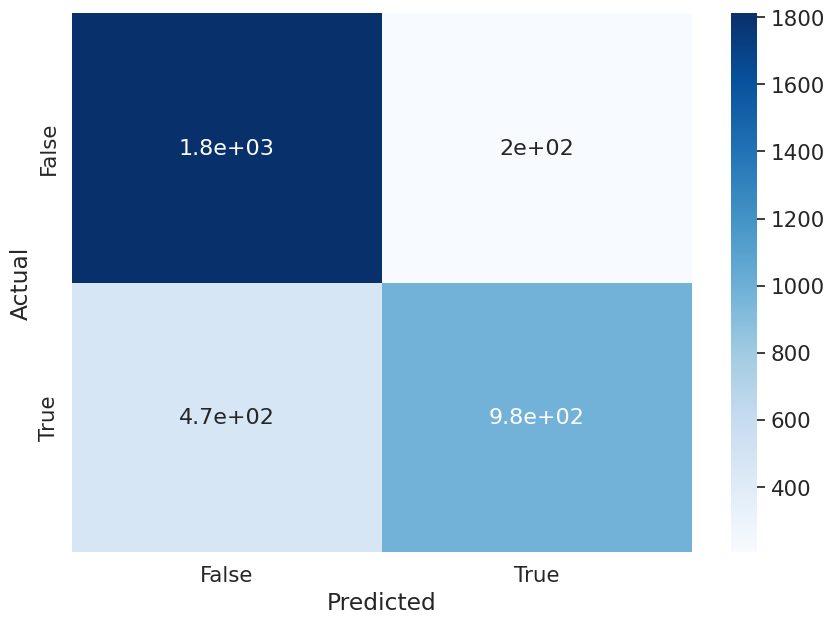

In [126]:
# generate confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


data = confusion_matrix(y_test_raw, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_raw), index = np.unique(y_test_raw))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

plt.show()

In [128]:
# Import the necessary libraries
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

# Balancing the data
X_resampled_raw, y_X_resampled_raw = rus.fit_resample(X_train_raw, y_train_raw)


In [136]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_resampled_raw, y_X_resampled_raw)

y_pred = gnb.predict(X_test_raw)

accuracy = accuracy_score(y_test_raw, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.8048498845265589
